# Embeddings

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/13_embeddings.ipynb)

Un embedding es un espacio vectorial, típicamente de menor dimensión que el espacio de entrada, que conserva la proximidad relativa de los ejemplos del espacio de entrada. 

Se utilizan para determinar fácilmente la relación entre objetos, por ejemplo para encontrar imágenes similares. Utilizando un embedding, la similitud entre dos imágenes queda sencillamente expresada por la diferencia entre dos vectores.

## Algunas aplicaciones

### Identificación de rostros

Dado una foto de una persona identificar su identidad en una base de datos de embeddings

### Sistemas de recomendación por imágenes

Dado la imagen de un producto sugerir productos de apariencia similar

<!-- ![Agrupación semática de objetos](images/product_embedding.png) -->

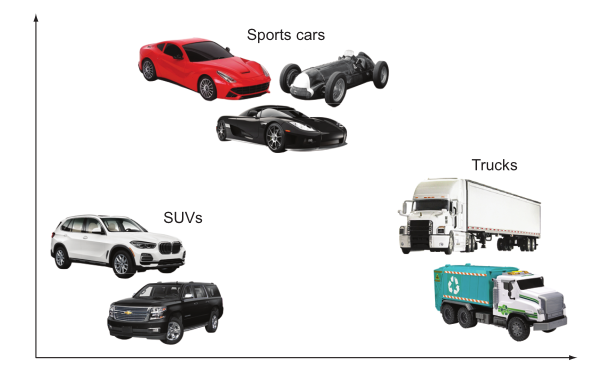

### Re-identificación de objetos

Dado una imagen de un objeto encontrar dicho objeto en múltiples imágenes (por ejemplo en un video de cámaras de seguridad)

<!-- ![Re-identificación de objetos](images/object_reidintification.png) -->

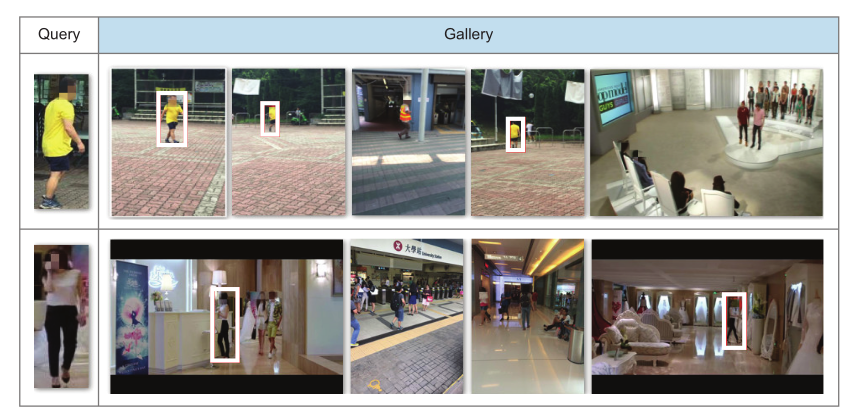


### Clasificación no supervisada

Encontrar agrupaciones de objetos similares a pesar de no tener etiquetas a disposición

## Autoencoders

Los autoencoders son un tipo especial de red neuronal que aprenden un embedding del espacio de entrada a partir de los datos mismos, sin necesidad de etiquetas. Esto lo logran al intentar reconstruir los datos originales luego de que estos fueran forzados a pasar por un espacio intermedio de baja dimensionalidad. 

En definitiva, los autoencoders aprenden a comprimir la información contenida en los datos en un embedding, de manera tal que sea posible regenerar los datos a partir del mismo.

El espacio vectorial del embedding es conocido también como el espacio latente del autoencoder.

<!-- ![Esquema de un autoencoder](images/autoencoder_schema.jpg) -->

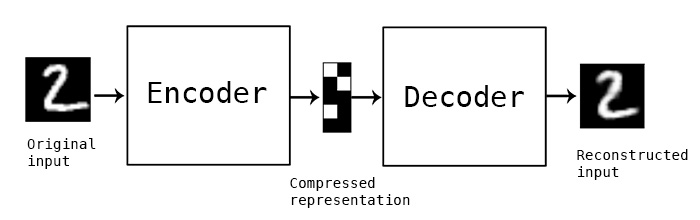

# Un ejemplo de autoencoder

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model

2023-07-02 17:32:14.550630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(mnist_train_data, mnist_validation_data), mnist_info = tfds.load('mnist', split=["train", "test"], with_info=True, as_supervised=True)

num_classes = 10

# def to_categorical(image, label):
#     return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)

def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def flatten(image, label):
    """ Flatten the image to a single column vector"""
    image = tf.reshape(image, shape=[-1])
    return image, label

def mnist_pipeline(dataset):
    dataset = dataset.map(normalize)
    # dataset = dataset.map(to_categorical)
    dataset = dataset.map(flatten)
    dataset = dataset.cache()
    return dataset

mnist_train_data = mnist_pipeline(mnist_train_data).shuffle(mnist_info.splits['train'].num_examples)
mnist_validation_data = mnist_pipeline(mnist_validation_data)

2023-07-02 17:32:16.038335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:32:16.041255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:32:16.041363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Como lo que tenemos que reproducir son los mismos datos de entrada, vamos a descartar las etiquetas y reemplazarlas por la misma imagen

In [3]:
duplicate_imgs_f = lambda image, label: (image, image)
mnist_train_data = mnist_train_data.map(duplicate_imgs_f)


extract_labels_f = lambda image, label: label
mnist_validation_labels = mnist_validation_data.map(extract_labels_f)
mnist_validation_data = mnist_validation_data.map(duplicate_imgs_f)

In [4]:
batch_size=256
mnist_train_data = mnist_train_data.batch(batch_size)
mnist_validation_data = mnist_validation_data.batch(batch_size)

La siguiente celda crea el enconder, el decoder y los junta en un solo modelo (el autoencoder)

In [5]:
encoding_dim = 32

input_img = layers.Input(shape=(784,))

encoder_layer = layers.Dense(encoding_dim, activation='relu')(input_img)
decoder = layers.Dense(784, activation='sigmoid')(encoder_layer)

autoencoder = Model(input_img, decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Como todos los pixeles estan entre cero y uno, podemos usar binary_crossentropy como función de perdida de la reconstrucción. Pero tengan en cuenta que existen otras alternativas, 

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
autoencoder.fit(
    mnist_train_data,
    epochs=50,
    validation_data=mnist_validation_data
)

2023-07-02 17:32:16.728051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-02 17:32:16.728490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


Epoch 1/50


2023-07-02 17:32:18.220771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 17:32:18.222748: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3547a0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 17:32:18.222764: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-07-02 17:32:18.229838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-02 17:32:18.397684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 17:32:18.475623: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/235 [=========================>....] - ETA: 0s - loss: 0.2868

2023-07-02 17:32:18.973705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-02 17:32:18.973957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


235/235 [==============================] - 2s 2ms/step - loss: 0.2775 - val_loss: 0.1931
Epoch 2/50
235/235 [==============================] - 0s 1ms/step - loss: 0.1728 - val_loss: 0.1551
Epoch 3/50
235/235 [==============================] - 0s 1ms/step - loss: 0.1457 - val_loss: 0.1351
Epoch 4/50
235/235 [==============================] - 0s 1ms/step - loss: 0.1294 - val_loss: 0.1217
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1183 - val_loss: 0.1127
Epoch 6/50
235/235 [==============================] - 0s 1ms/step - loss: 0.1108 - val_loss: 0.1069
Epoch 7/50
235/235 [==============================] - 0s 1ms/step - loss: 0.1058 - val_loss: 0.1028
Epoch 8/50
235/235 [==============================] - 0s 1ms/step - loss: 0.1022 - val_loss: 0.0996
Epoch 9/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0997 - val_loss: 0.0974
Epoch 10/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0979 - val_loss: 0.0959
Epoch 11/5

In [8]:
mnist_validation_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 784), dtype=tf.float32, name=None))>

In [9]:
encoder = Model(input_img, encoder_layer)

encoded_imgs = encoder.predict(mnist_validation_data)

 1/40 [..............................] - ETA: 1s

40/40 [==============================] - 0s 633us/step


In [10]:
encoded_imgs.shape

(10000, 32)

En la próxima celda creamos un modelo también para el decoder

In [11]:
encoded_input = layers.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [12]:
encoded_imgs = encoder.predict(mnist_validation_data)

decoded_images = decoder.predict(encoded_imgs)

40/40 [==============================] - 0s 674us/step


313/313 [==============================] - 0s 458us/step


2023-07-02 17:32:38.634750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-02 17:32:38.635201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


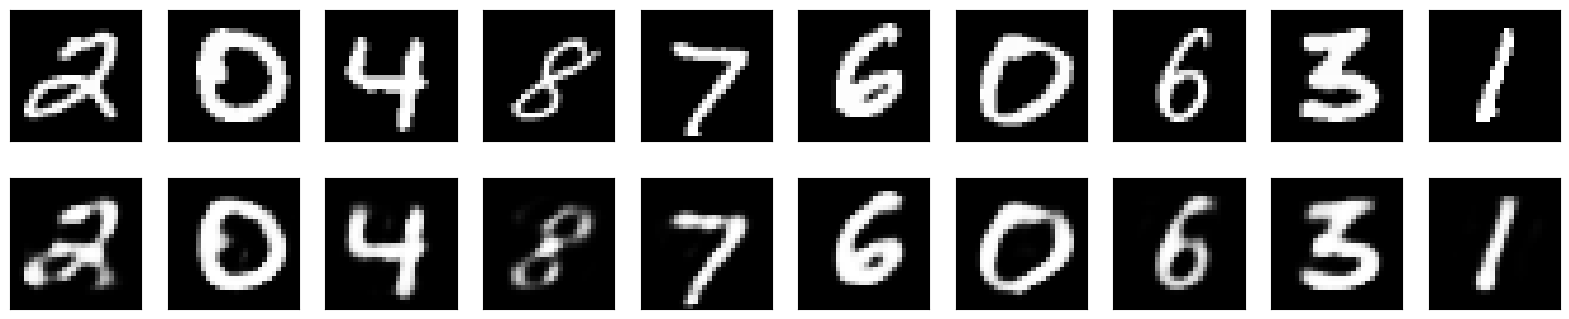

In [13]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i, image in enumerate(tfds.as_numpy(mnist_validation_data.unbatch().take(n))):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
import umap

reducer = umap.UMAP(n_components=2)

reducer.fit(encoded_imgs)

u = reducer.transform(encoded_imgs)

/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [15]:
# obtener todas las etiquetas de validación
labels = tfds.as_numpy(list(mnist_validation_labels))

2023-07-02 17:33:09.038885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 17:33:09.039239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

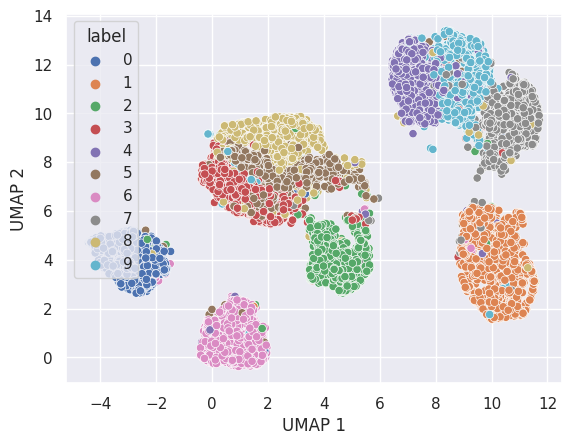

In [16]:
import seaborn as sns
import pandas as pd
sns.set_theme()

data = pd.DataFrame({"UMAP 1": u[:, 0], "UMAP 2": u[:, 1], "label": labels})
data["label"] = data["label"].astype("category")

sns.scatterplot(data=data, x="UMAP 1", y="UMAP 2", hue="label")

## Autoencoder convolucional

In [17]:
input_img = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)



x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

In [18]:
(mnist_train_data, mnist_validation_data), mnist_info = tfds.load('mnist', split=["train", "test"], with_info=True, as_supervised=True)

def mnist_pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.cache()
    return dataset

mnist_train_data = mnist_pipeline(mnist_train_data).shuffle(mnist_info.splits['train'].num_examples)
mnist_validation_data = mnist_pipeline(mnist_validation_data)

# duplicar imagenes de entrenamiento
mnist_train_data = mnist_train_data.map(duplicate_imgs_f)

# guardar etiquetas y luego duplicar imagenes de validacion
mnist_validation_labels = mnist_validation_data.map(extract_labels_f)
mnist_validation_data = mnist_validation_data.map(duplicate_imgs_f)


# crear batchs
batch_size=256
mnist_train_data = mnist_train_data.batch(batch_size)
mnist_validation_data = mnist_validation_data.batch(batch_size)

Vamos a usar `TensorBoard` para monitorear el progreso

In [19]:
from tensorflow.keras.callbacks import TensorBoard

In [20]:
%load_ext tensorboard
%tensorboard --logdir logs

Launching TensorBoard...

In [21]:
autoencoder.fit(
    mnist_train_data,
    epochs=600,
    validation_data=mnist_validation_data,
    callbacks=[
        TensorBoard(log_dir='logs/autoencoder')
    ]
)

Epoch 1/600


2023-07-02 17:33:12.610109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-02 17:33:12.610387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


235/235 [==============================] - ETA: 0s - loss: 0.2646

2023-07-02 17:33:16.856073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 17:33:16.856384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


235/235 [==============================] - 5s 6ms/step - loss: 0.2646 - val_loss: 0.1680
Epoch 2/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1551 - val_loss: 0.1431
Epoch 3/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1374 - val_loss: 0.1318
Epoch 4/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1280 - val_loss: 0.1238
Epoch 5/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1224 - val_loss: 0.1195
Epoch 6/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1187 - val_loss: 0.1159
Epoch 7/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1158 - val_loss: 0.1137
Epoch 8/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1135 - val_loss: 0.1114
Epoch 9/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1116 - val_loss: 0.1105
Epoch 10/600
235/235 [==============================] - 1s 3ms/step - loss: 0.1099 - val_loss: 0.1081
E

40/40 [==============================] - 0s 903us/step


2023-07-02 17:40:56.026247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-02 17:40:56.026653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


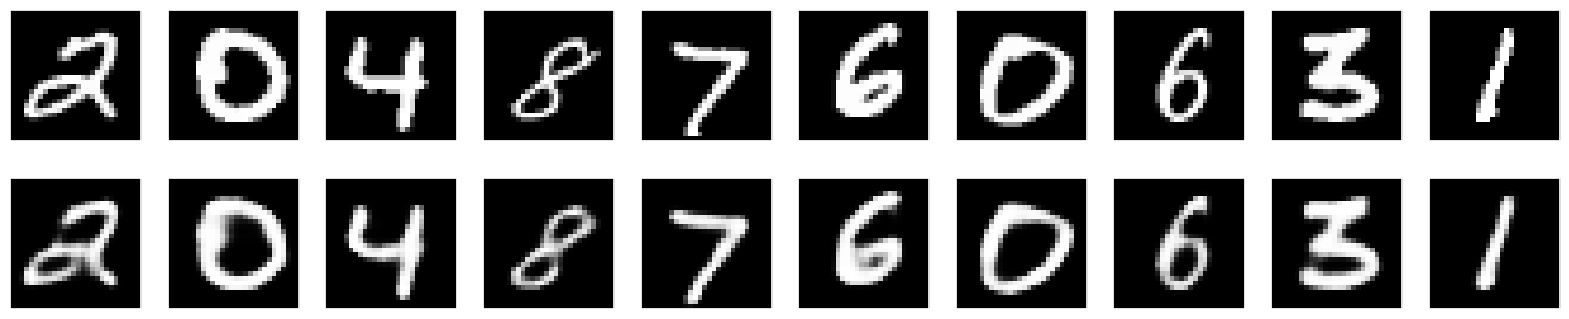

In [22]:
decoded_imgs = autoencoder.predict(mnist_validation_data)

import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i, image in enumerate(tfds.as_numpy(mnist_validation_data.unbatch().take(n))):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Outlier detection

Los autoencoders también son muy útiles para encontrar ejemplos de datos que se alejan de la norma.

In [23]:
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

losses = []
for batch in mnist_train_data:
    reconstructions = autoencoder.predict(batch[0])

    # compute the loss for all batch examples
    batch_losses = binary_crossentropy(reconstructions, batch[0])
    batch_losses = tf.reduce_mean(batch_losses, axis=(1, 2))
    
    
    losses.append(batch_losses.numpy())

# merge losses
losses = np.concatenate(losses)

3/3 [==============================] - 0s 1ms/step


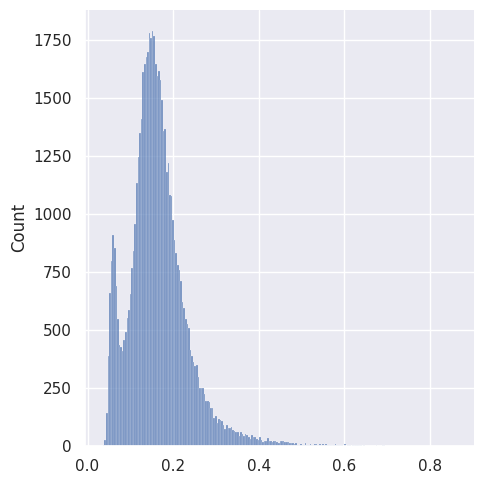

In [24]:
sns.displot(losses)

In [25]:
idx = np.where(losses >= 0.8)

images = []
reconstructions = []

for i, example in enumerate(mnist_train_data.unbatch().batch(1)):
    if i in idx[0]:
        images.append(example[0][0].numpy())
        reconstructions.append(autoencoder.predict(example[0]))



2023-07-02 17:41:05.527163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-02 17:41:05.527520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 11ms/step


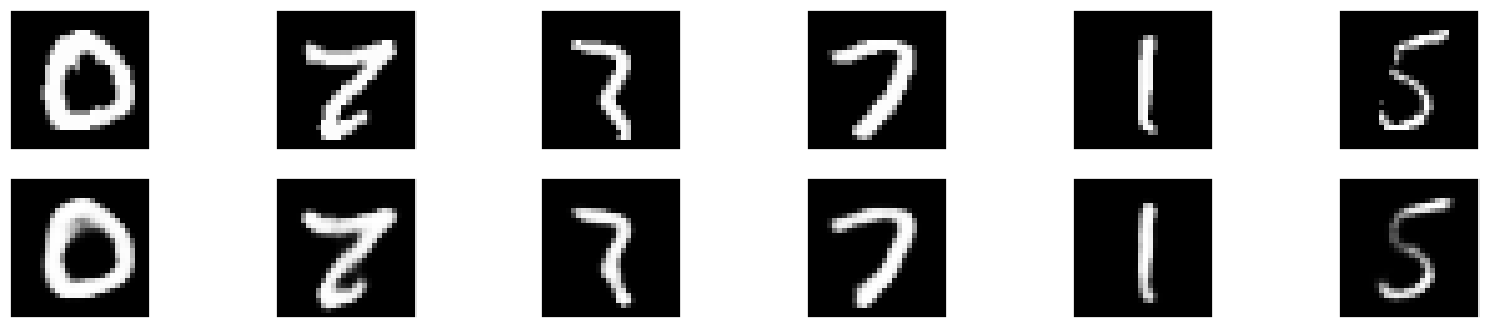

In [26]:
n = len(images)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoiser autoencoder

Los autoencoder también suelen ser usados para remover ruido de imágenes

In [27]:
import numpy as np

noise_factor = 0.3

def add_noise(image_0, image_1):
    image_0 = image_0 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(28, 28, 1)) 
    image_0 = tf.clip_by_value(image_0, 0., 1.)
    return image_0, image_1

In [28]:
(mnist_train_data, mnist_validation_data), mnist_info = tfds.load('mnist', split=["train", "test"], with_info=True, as_supervised=True)

def mnist_pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.cache()
    return dataset

mnist_train_data = mnist_pipeline(mnist_train_data).shuffle(mnist_info.splits['train'].num_examples)
mnist_validation_data = mnist_pipeline(mnist_validation_data)

# duplicar imagenes de entrenamiento
mnist_train_data = mnist_train_data.map(duplicate_imgs_f)
mnist_train_data = mnist_train_data.map(add_noise)

# guardar etiquetas y luego duplicar imagenes de validacion
mnist_validation_labels = mnist_validation_data.map(extract_labels_f)
mnist_validation_data = mnist_validation_data.map(duplicate_imgs_f)
mnist_validation_data = mnist_validation_data.map(add_noise)



2023-07-02 17:41:12.476294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-02 17:41:12.476641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-02 17:41:12.649758: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

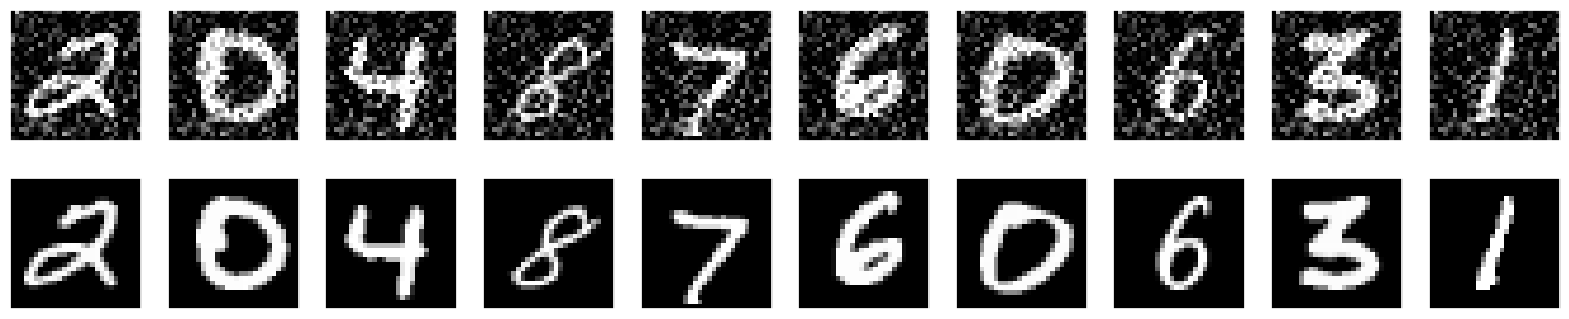

In [29]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i, image in enumerate(tfds.as_numpy(mnist_validation_data.take(n))):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(image[1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
# crear batchs
batch_size=256
mnist_train_data = mnist_train_data.batch(batch_size)
mnist_validation_data = mnist_validation_data.batch(batch_size)

In [31]:
input_img = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)



x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [32]:
denoising_autoencoder.fit(
    mnist_train_data,
    epochs=50,
    validation_data=mnist_validation_data,
    callbacks=[
        TensorBoard(log_dir='logs/denoising_autoencoder')
    ]
)

Epoch 1/50


2023-07-02 17:41:12.871996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-02 17:41:12.872270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


218/235 [==========================>...] - ETA: 0s - loss: 0.3023

2023-07-02 17:41:15.355855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 17:41:15.356104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


235/235 [==============================] - 3s 4ms/step - loss: 0.2941 - val_loss: 0.1907
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1686 - val_loss: 0.1719
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1491 - val_loss: 0.1622
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1379 - val_loss: 0.1611
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1313 - val_loss: 0.1535
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1272 - val_loss: 0.1544
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1240 - val_loss: 0.1550
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1216 - val_loss: 0.1517
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1196 - val_loss: 0.1498
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1181 - val_loss: 0.1487
Epoch 11/5

40/40 [==============================] - 0s 1ms/step


2023-07-02 17:41:55.698243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-02 17:41:55.698609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


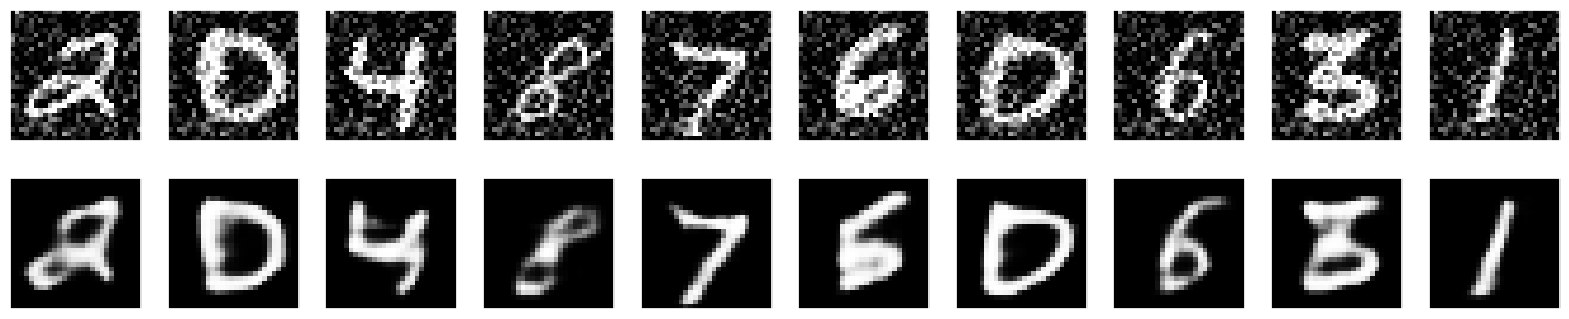

In [33]:
decoded_imgs = denoising_autoencoder.predict(mnist_validation_data)

import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i, image in enumerate(tfds.as_numpy(mnist_validation_data.unbatch().take(n))):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()